In [1]:
#<img src="Figs/GEOS_logo.pdf" width="500"/>

# Statistical testing tools for synthetic data sets: 
## <font color=blue>"stat_synthetic.ipynb"</font>
#### Feb 10, 2022  <font color=red>(v. testing)</font>
##### Jeonghyeop Kim (jeonghyeop.kim@gmail.com)

1. This code is a part of the joint inversion project (project4: joint inversion of GNSS and InSAR)

2. The followings will be plotted and saved:
- The "L-curve"
- The misfit of 3-D motion as a function of damping parameters
- The "heat map" as a function of relative weighting values


**`Note that a "true" 3-D field is only available for synthetic data sets`**


In [2]:
## Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

In [3]:
## Initialization

inversion_type='L2'  #'L1' or 'L2'
subdir_name = 'input_files' # the name of a subdirectory where your input files are

cwd = os.getcwd()
path=os.path.join(cwd, subdir_name)

print("Statistical tests for the %s inversion results.\n" %inversion_type)
print("Save %s_stat* & %s_model_coef* files in the following directory:\n" %(inversion_type,inversion_type))
print("'%s'" %path)

## Assign a list of names made of param.

if inversion_type=='L2':     
    names=['wI','wG','alpha','beta']
    
elif inversion_type=='L1':
    names=['wI','wG','alpha']    
    
else: #stop the code
    print(" ********************************************** ")
    print(" * inversion_type must be either 'L2' or 'L1' * ")      
    print(" ********************************************** ")

    exit() 

Statistical tests for the L2 inversion results.

Save L2_stat* & L2_model_coef* files in the following directory:

'/Users/jkim/main/Joint_GNSS_INSAR/statistical_testing_tools_02092022/input_files'


In [4]:
## Define ComputeModelNorm function

def ComputeModelNorm(model_arr,inversion='L2'):
    if inversion=='L2':
        norm_type=2
    else:
        norm_type=1   
    model_norm=np.linalg.norm(model_arr,norm_type)
    
    return model_norm

In [5]:
## Define MakeFileName function 

def MakeFileName(head,ext,paramList):
    
    glue = '_'
    paramList_glue = glue.join(paramList)
    filename = head + paramList_glue + ext
    
    return filename

In [6]:
## Extract all combinations of the parameter variables 

### wI : relative weighting for InSAR
### wG : relative weighting for GNSS
### alpha : 1st regularization param. 
### beta  : 2nd regularization param. (for L2 only)

load_params = []
scan_file = inversion_type+'_stat_'

if inversion_type=='L2':
    
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][2]
                element4=entry.name.split("_")[2:][-1][0:-4] 
                # [0:-4] means without extension (e.g., .dat or .txt)
                list_elements = [element1, element2, element3, element4]
                load_params.append(list_elements)

elif inversion_type=='L1':
    
    with os.scandir(path) as it: #scan the directory
        for entry in it:
            if entry.name.startswith(scan_file) and entry.is_file():
                element1=entry.name.split("_")[2:][0]
                element2=entry.name.split("_")[2:][1]
                element3=entry.name.split("_")[2:][-1][0:-4]
                # [0:-4] means without extension(e.g., .dat or .txt)
                list_elements = [element1, element2, element3]
                load_params.append(list_elements)        
    
df_param_string = pd.DataFrame(load_params,columns=names)
df_param_numeric = df_param_string.astype(float)

In [7]:
## Compute model norms and data misfits

model_norms = []
misfits = []

for i in range(len(df_param_string)):
    paramList=df_param_string.iloc[i,:].values
    
    ## Calculate & save model norms
    head = inversion_type + '_model_coef_'
    ext = '.dat'
    filename_model=MakeFileName(head,ext,paramList)
    model_arr = np.loadtxt(path+'/'+filename_model)
    model_norm=ComputeModelNorm(model_arr,inversion=inversion_type)
    model_norms.append(model_norm)
    
    ## Save inversion misfits
    head = inversion_type + '_stat_'
    ext = '.txt'
    filename_stat=MakeFileName(head,ext,paramList)
    stat_arr = np.loadtxt(path+'/'+filename_stat)
    misfits.append(float(stat_arr))
    
df_param_numeric['model_norm']=model_norms
df_param_numeric['model_misfit']=misfits

### (1). PLOTS
- (a) Fix wI & wG values for each subplot -> **models norm vs. data misfit (L-curve)** 
- (b) Fix alpha (& beta) for each subplot -> **wI-wG vs. data misfit (Heatmap)**

### (2). ADDITIONAL PLOTS for synthetic data,
- (a) Fix wI & wG values for each subplot -> **models norm vs. 3-D field misfit (L-curve)**
- (b) Fix alpha (& beta) for each subplot -> **wI-wG vs. 3-D misfit (Heatmap)**

In [8]:
## dictionary for columns and unique values pairs 
dict_unique = {} 
for col in names: 
    unique_values = pd.unique(df_param_numeric[col].sort_values(ascending=True)).tolist()
    dict_unique["{0}".format(col)] = unique_values

#### (1)-(a). PLOTS

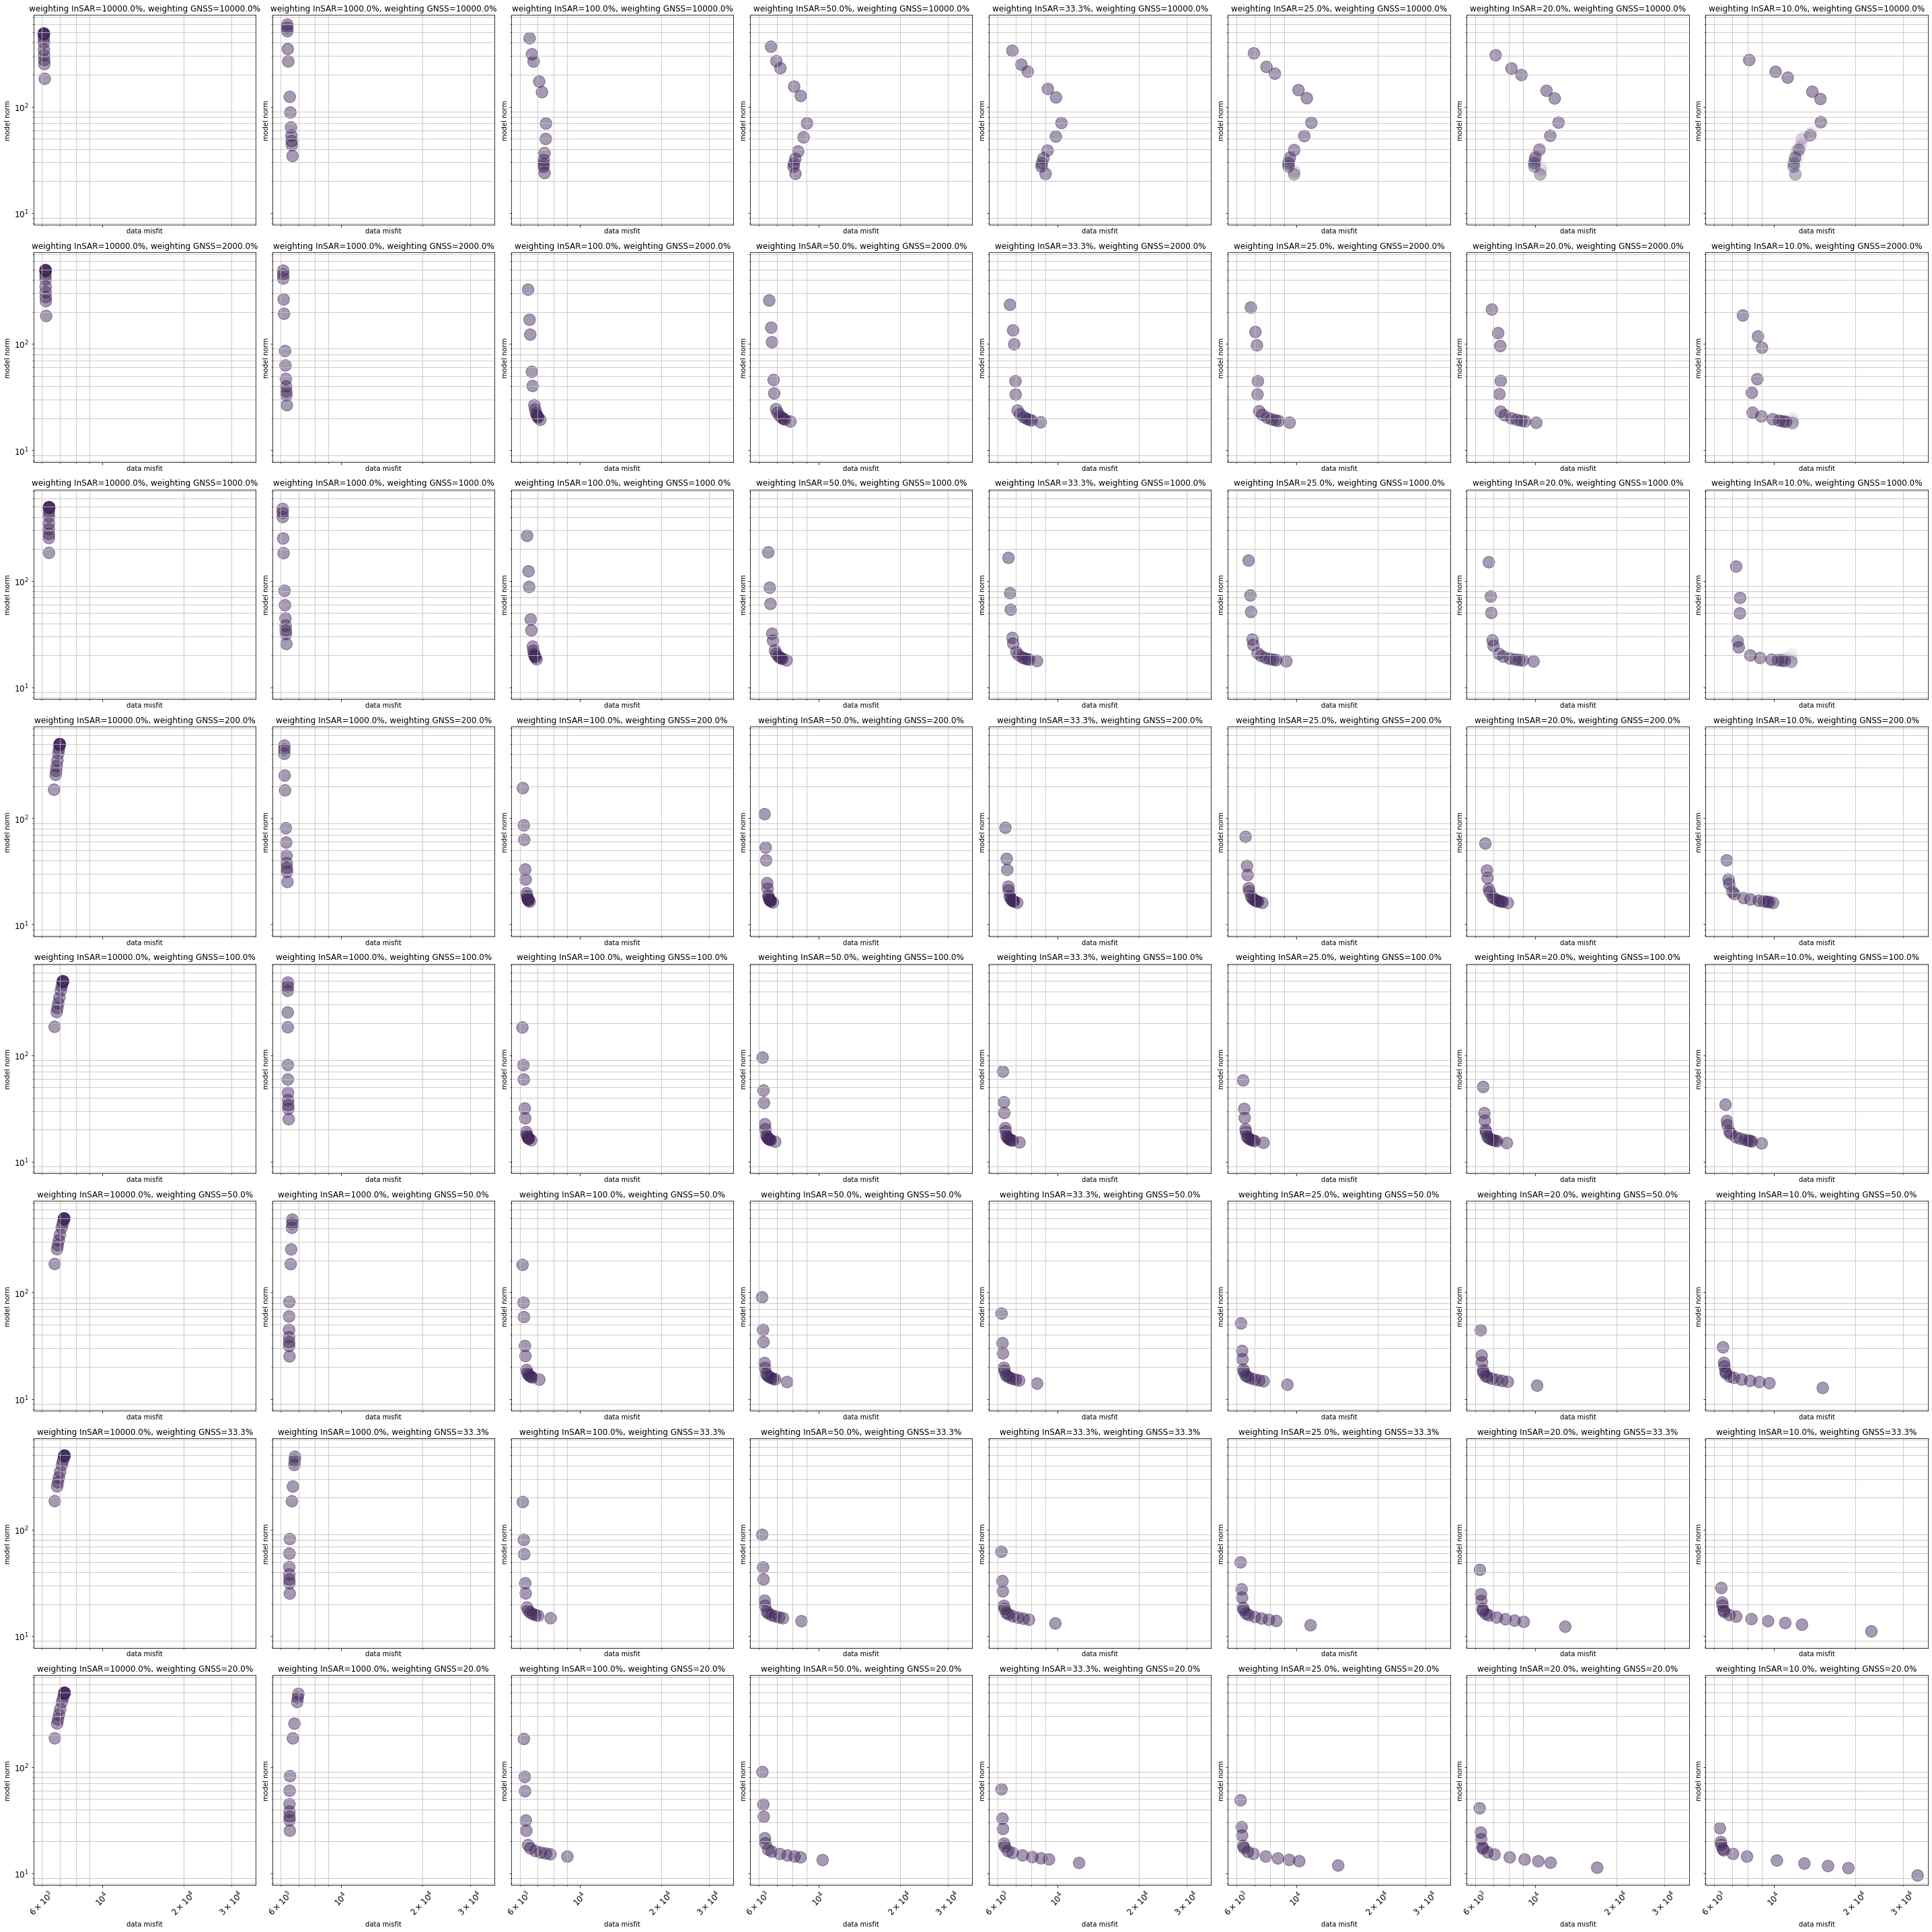

In [268]:
ncols = len(dict_unique['wI'])
nrows = len(dict_unique['wG'])
scale = 1
tickFont = 12
fig, ax = plt.subplots(figsize = (40*scale,40*scale), ncols = ncols, nrows = nrows, sharex=True, sharey=True)



for col in range(ncols): #wI
    for row in range(nrows): #wG
        wI_search = dict_unique['wI'][col]
        wG_search = dict_unique['wG'][row]
        df_search = df_param_numeric[(df_param_numeric.wI == wI_search) & (df_param_numeric.wG == wG_search)]

        
        if inversion_type == 'L2':
            df_search = df_search.sort_values(['alpha', 'beta'], ascending=False)
            beta = df_search['beta']
            x = df_search['model_misfit']
            y = df_search['model_norm']
            alpha = df_search['alpha']
            ax[row,col].grid(True, color='0.75',linestyle='-',which='minor')
            ax[row,col].set_xscale('log')
            ax[row,col].set_yscale('log')  
            ax[row,col].set_xlabel('data misfit')
            ax[row,col].set_ylabel('model norm')
            ax[row,col].tick_params(axis='x', labelsize=tickFont*scale, rotation=45, which='both')
            ax[row,col].tick_params(axis='y', labelsize=tickFont*scale, which='both') 
            ax[row,col].set_title('weighting InSAR=%0.1f%%; weighting GNSS=%0.1f%%' % (1/wI_search*100, 1/wG_search*100))
            
            ax[row,col].scatter(x, y, c = beta, s=300, alpha = 0.05) # s=size
            #ax[row,col].plot(x, y)

        else:
            df_search = df_search.sort_values(['alpha'])
            x = df_search['model_misfit']
            y = df_search['model_norm']
            alpha = df_search['alpha']

            
            ax[row,col].grid(True, color='0.75',linestyle='-',which='minor')
            ax[row,col].set_xscale('log')
            ax[row,col].set_yscale('log')
            ax[row,col].tick_params(axis='x', labelsize=tickFont*scale, rotation=45, which='both')
            ax[row,col].tick_params(axis='y', labelsize=tickFont*scale, which='both') 
            ax[row,col].set_title('wI=%0.1f%%, wG=%0.1f%%' % (1/wI_search*100, 1/wG_search*100))
            
            ax[row,col].scatter(x, y, c = beta, s=300, alpha = 0.05) # s=size
            #ax[row,col].plot(x, y)
            
fig.tight_layout() # no overlap

#### (1)-(b). PLOTS

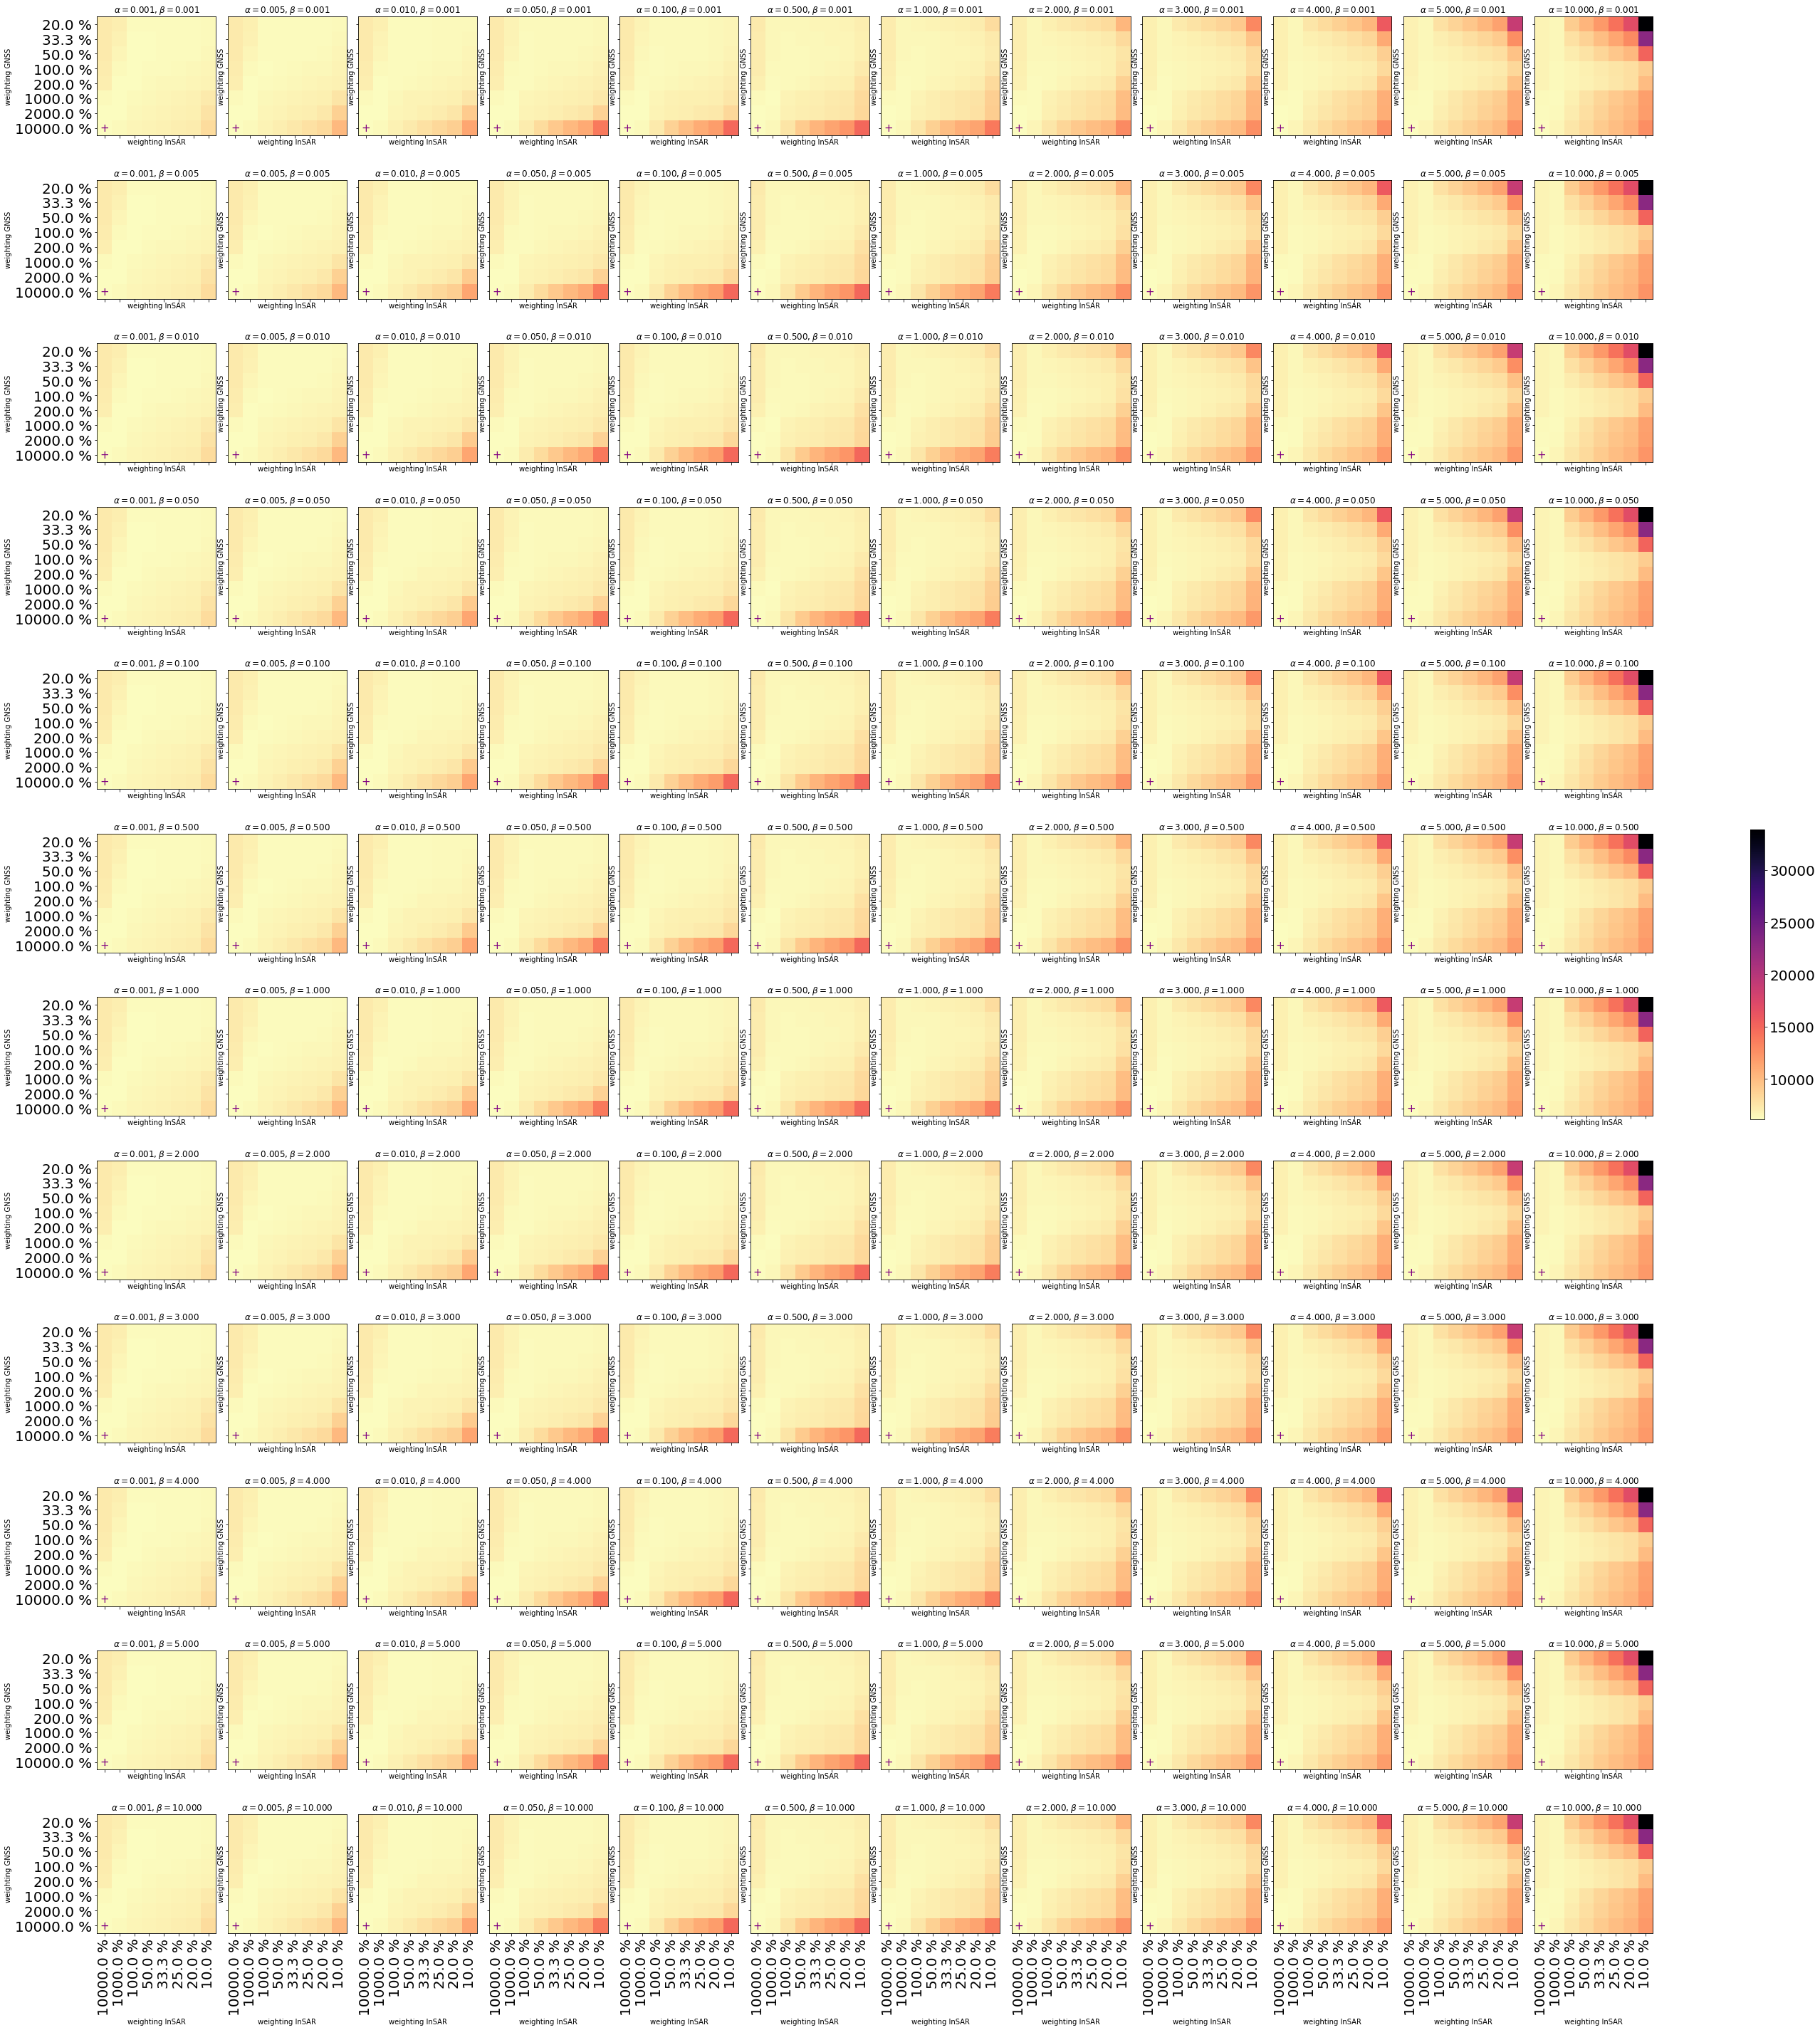

In [286]:
scale = 1
tickFont = 12


vmin=df_param_numeric['model_misfit'].min()
vmax=df_param_numeric['model_misfit'].max()

ncols = len(dict_unique['alpha'])
nrows = len(dict_unique['beta'])
fig, ax = plt.subplots(figsize = (40*scale,40*scale), ncols = ncols, nrows = nrows, sharex=True, sharey=True)

for col in range(ncols): #alpha
    for row in range(nrows): #beta
        a_search = dict_unique['alpha'][col]
        b_search = dict_unique['beta'][row]
        df_search = df_param_numeric[(df_param_numeric.alpha == a_search) & (df_param_numeric.beta == b_search)]
        df_search = df_search.sort_values(['wG', 'wI'], ascending=True)
        x = dict_unique['wI']
        x = np.round(1/np.array(x)*100,1).astype(str).tolist()
        pst_sign = [" %"] * len(x)
        x_fin = [a + b for a, b in zip(x, pst_sign)]
        
        y = dict_unique['wG']
        y = np.round(1/np.array(y)*100,1).astype(str).tolist()
        pst_sign = [" %"] * len(y)
        y_fin = [a + b for a, b in zip(y, pst_sign)]
        
        z = df_search['model_misfit'].values.reshape(len(dict_unique['wG']),len(dict_unique['wI']))
        z = z
        z_arr = np.array(z)
        im = ax[row,col].imshow(z, cmap = 'magma_r', origin='lower', vmin = vmin, vmax = vmax) #origin = 'lower' upside-down #vmin=-1.2, vmax=1.2
        

    
        
        colmin=np.argmin(np.min(z_arr, axis=1))
        rowmin=np.argmin(np.min(z_arr, axis=0))
        ax[row,col].text(rowmin,colmin, '+',size=15, color='purple', ha='center', va='center')
        
        ax[row,col].set_xticks(np.arange(len(x_fin)))
        ax[row,col].set_yticks(np.arange(len(y_fin)))
        ax[row,col].set_xticklabels(x_fin)
        ax[row,col].set_yticklabels(y_fin)

        ax[row,col].tick_params(axis='x', rotation=90)
        
        ax[row,col].set_title(r'$\alpha=%0.3f, \beta=%0.3f$' % (a_search, b_search))
        ax[row,col].set_xlabel('weighting InSAR')
        ax[row,col].set_ylabel('weighting GNSS')        
        # if col == (ncols-1):
        #     fig.colorbar(im, ax=ax[row,col])

        
# fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# fig.colorbar(cax=cax)            
 # no overlap
fig.tight_layout()
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
fig.colorbar(im, ax=ax.ravel().tolist(),shrink=0.15)

In [ ]:
# list_test = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
# arr = np.array([list_test])

In [92]:
# 1/(arr/100)

array([[5.        , 2.5       , 1.66666667, 1.25      , 1.        ,
        0.83333333, 0.71428571, 0.625     , 0.55555556, 0.5       ]])

In [13]:
#pd.set_option('display.max_rows', 10)

In [14]:
# ## Obtain norms of the column vectors in the G matrix
# df_G=pd.read_csv(path+'/'+'G_matrix.out')
# n_col=df_G.shape[1]
# df_G.columns=[i for i in range(n_col)]
# G = df_G.to_numpy()

# amp_column=np.linalg.norm(G,axis=0) #column vectors' magnitudes

# ##normalized_model = norm_column * model